In [1]:
import numpy as np
import scipy as sp
import scipy.ndimage as ndimage
import random

import pollution

import matplotlib.pyplot as plt
import matplotlib
from tqdm import trange
import tqdm
import os
import imageio.v2 as imageio
import math
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import networkx as nx
import os
import math
import matplotlib.ticker as mtick
import ipywidgets as widgets
from scipy.optimize import minimize_scalar, minimize
from matplotlib.lines import Line2D

font = {        'size'   : 20}
mpl.rc('font', **font)
# %matplotlib notebook
def multicolour_marker(pos,c_t,c_w,ax,angle=0,scale=1,boxc='black'):
    half_1 = mpl.patches.Rectangle(pos, scale/2,scale,angle=angle,facecolor=c_t)
    half_2 = mpl.patches.Rectangle([pos[0]+scale/2,pos[1]],
                                   scale/2,scale,angle=angle,facecolor=c_w)
    box = mpl.patches.Rectangle(pos,scale,scale,angle=angle,facecolor='none',edgecolor=boxc)
    ax.add_artist(half_1)
    ax.add_artist(half_2)
    ax.add_artist(box)

In [27]:
T = 200
N = 100
D = 3*N//5
L = 20
mu_poor = 0.8
mu_rich = 1-mu_poor
mu=[mu_poor]*(4*N//5) + [mu_rich]*(N//5)
random.shuffle(mu)

pcp = np.zeros(T+1)
pce = np.zeros(T+1)
dist_moved_d = np.zeros([D,T+1])
dist_moved_c = np.zeros([N-D,T+1])

world = pollution.World(L=L,N=N,D=D,phi=5,R=5,M_nu=0,epsilon=0,mu=mu)
# for i in trange(T+1):
#     pcp[i]=world.per_capita_pollution()
#     pce[i]=world.per_capita_expense()
#     world.step()
with imageio.get_writer(f'Animation/two_cost_L{L}N{N} c.gif', mode='I') as writer:
    for i in trange(T+1):
        fig,ax=plt.subplots(figsize=(6,6))
#         ax.imshow(world.pollution_grid,cmap='bwr',vmin=-3,vmax=3) 
        for a in world.agents:
            if a.type=='c':
                t_col = '#8cdcda'
            else:
                t_col = '#f16a70'
            if a.mu == mu_rich:
                w_col = '#b1d877'
            else:
                w_col = '#4d4d4d'
            multicolour_marker(a.position,w_col,t_col,ax,boxc='k')
        pcp[i] = world.per_capita_pollution()
        pce[i] = world.per_capita_expense()
        dist_moved_d[:,t] = [a.dist_moved for a in world.agents if a.type=='d']
        dist_moved_c[:,t] = [a.dist_moved for a in world.agents if a.type=='c']
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.set_xlim([0,L])
        ax.set_ylim([0,L])
        fig.savefig(f'Animation/{i}.png',bbox_inches='tight')
        plt.close()
        world.step()
        image = imageio.imread(f'Animation/{i}.png')
        writer.append_data(image)
        os.remove(f'Animation/{i}.png')

100%|█████████████████████████████████████████| 201/201 [01:08<00:00,  2.95it/s]


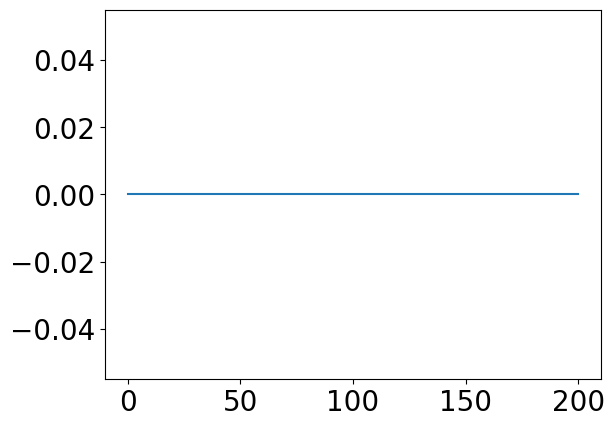

In [28]:
plt.plot(dist_moved_d.mean(axis=0))

In [3]:
folder = 'Data/Fixed Strategy/Two cost fixed mean/N80/04_'
T=200
N=80
D=[16,32,48,64]
R=5
phi=5
L = 50
runs=50
mu_min= np.arange(0,1.05,0.05)
mu_maj= 0.5-mu_min/4

pcp = np.zeros((len(D),len(mu_min),runs))
pcp_type = np.zeros((2,2,len(D),len(mu_min),runs))
cc = np.zeros((len(D),len(mu_min),runs))
cc_type = np.zeros((2,2,len(D),len(mu_min),runs))

for i in range(len(D)):
    for k in trange(runs):
        for j in range(len(mu_min)):
#             mu_M = 0.5-mu_min[j]/4
            mu = [mu_min[j]]*(N//5) + [mu_maj[j]]*(4*N//5)
            random.shuffle(mu)
            world = pollution.World(L=L,N=N,D=D[i],phi=5,R=5,M_nu=0,mu=mu)
            pcp[i,j,k] -= world.per_capita_pollution()
            for t in range(T):
                world.step()
            pcp[i,j,k] += world.per_capita_pollution()
            pcp_type[0,0,i,j,k] = np.nanmean([world.pollution_grid[a.position] 
                                           for a in world.agents 
                                           if a.type=='c' and a.mu==mu_maj[j]])
            pcp_type[0,1,i,j,k] = np.nanmean([world.pollution_grid[a.position] 
                                           for a in world.agents 
                                           if a.type=='d' and a.mu==mu_maj[j]])
            pcp_type[1,0,i,j,k] = np.nanmean([world.pollution_grid[a.position] 
                                           for a in world.agents 
                                           if a.type=='c' and a.mu==mu_min[j]])
            pcp_type[1,1,i,j,k] = np.nanmean([world.pollution_grid[a.position] 
                                           for a in world.agents 
                                           if a.type=='d' and a.mu==mu_min[j]])
            clusters = world.observe_clusters()
            if len(clusters)>0:
                for c in range(len(clusters)):
                    clusters[0].update(clusters[c])
                cc[i,j,k] = len(clusters[0])/len(world.agents)
                cc_type[:,:,i,j,k] = world.cluster_breakdown(ccs=clusters,mu_vals=[mu_maj[j],mu_min[j]])
np.savetxt(folder+'pcp.csv',pcp.reshape(len(D)*len(mu_min),runs))
np.savetxt(folder+'pcp_type.csv',pcp_type.reshape(2*2*len(D)*len(mu_min),runs))
np.savetxt(folder+'cc.csv',cc.reshape(len(D)*len(mu_min),runs))
np.savetxt(folder+'cc_type.csv',cc_type.reshape(2*2*len(D)*len(mu_min),runs))

100%|███████████████████████████████████████████| 50/50 [43:21<00:00, 52.03s/it]


In [4]:
folder = 'Data/Fixed Strategy/Two cost fixed mean/N80/08_'
T=200
N=80
D=[16,32,48,64]
R=5
phi=5
L = 50
runs=50
mu_min= np.arange(0,1.05,0.05)
mu_maj= 1-mu_min/4

pcp = np.zeros((len(D),len(mu_min),runs))
pcp_type = np.zeros((2,2,len(D),len(mu_min),runs))
cc = np.zeros((len(D),len(mu_min),runs))
cc_type = np.zeros((2,2,len(D),len(mu_min),runs))

for i in range(len(D)):
    for k in trange(runs):
        for j in range(len(mu_min)):
#             mu_M = 0.5-mu_min[j]/4
            mu = [mu_min[j]]*(N//5) + [mu_maj[j]]*(4*N//5)
            random.shuffle(mu)
            world = pollution.World(L=L,N=N,D=D[i],phi=5,R=5,M_nu=0,mu=mu)
            pcp[i,j,k] -= world.per_capita_pollution()
            for t in range(T):
                world.step()
            pcp[i,j,k] += world.per_capita_pollution()
            pcp_type[0,0,i,j,k] = np.nanmean([world.pollution_grid[a.position] 
                                           for a in world.agents 
                                           if a.type=='c' and a.mu==mu_maj[j]])
            pcp_type[0,1,i,j,k] = np.nanmean([world.pollution_grid[a.position] 
                                           for a in world.agents 
                                           if a.type=='d' and a.mu==mu_maj[j]])
            pcp_type[1,0,i,j,k] = np.nanmean([world.pollution_grid[a.position] 
                                           for a in world.agents 
                                           if a.type=='c' and a.mu==mu_min[j]])
            pcp_type[1,1,i,j,k] = np.nanmean([world.pollution_grid[a.position] 
                                           for a in world.agents 
                                           if a.type=='d' and a.mu==mu_min[j]])
            clusters = world.observe_clusters()
            if len(clusters)>0:
                for c in range(len(clusters)):
                    clusters[0].update(clusters[c])
                cc[i,j,k] = len(clusters[0])/len(world.agents)
                cc_type[:,:,i,j,k] = world.cluster_breakdown(ccs=clusters,mu_vals=[mu_maj[j],mu_min[j]])
np.savetxt(folder+'pcp.csv',pcp.reshape(len(D)*len(mu_min),runs))
np.savetxt(folder+'pcp_type.csv',pcp_type.reshape(2*2*len(D)*len(mu_min),runs))
np.savetxt(folder+'cc.csv',cc.reshape(len(D)*len(mu_min),runs))
np.savetxt(folder+'cc_type.csv',cc_type.reshape(2*2*len(D)*len(mu_min),runs))

100%|███████████████████████████████████████████| 50/50 [44:09<00:00, 52.99s/it]


In [4]:
folder='Data/Fixed Strategy/Two cost fixed mean/04_'
pcp = np.loadtxt(folder+'pcp.csv').reshape(4,len(np.arange(0,1.05,0.05)),50)
pcp_type = np.loadtxt(folder+'pcp_type.csv').reshape(2,2,4,len(np.arange(0,1.05,0.05)),50)
cc = np.loadtxt(folder+'cc.csv').reshape(4,len(np.arange(0,1.05,0.05)),50)
cc_type = np.loadtxt(folder+'cc_type.csv').reshape(2,2,4,len(np.arange(0,1.05,0.05)),50)

D=[10,20,30,40]
R=5
phi=5
L = 50
runs=50
mu_min=np.arange(0,1.05,0.05)
D_corners = [5,15,25,35,45]
mu_rich_corners = np.diff(np.array([-0.05]+list(mu_min)+[1.05]))/2 + np.arange(-0.05,1.05,0.05)

mu_mesh,D_mesh = np.meshgrid(mu_rich_corners,D_corners)
folder_fig = 'Figures/Fixed Strategy/Two cost fixed mean/04_'

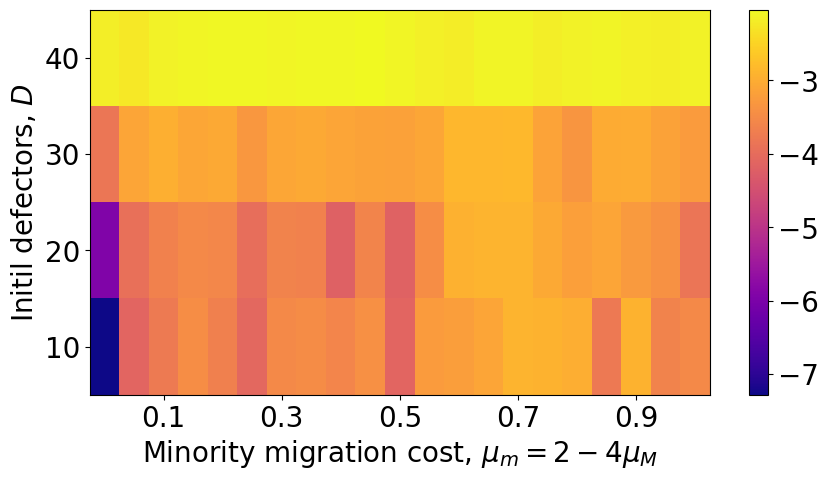

In [4]:
fig,ax = plt.subplots(figsize=(10,5))
# im=ax.imshow(pcp.mean(axis=-1),cmap='plasma',origin='lower')
im=ax.pcolormesh(mu_mesh,D_mesh,pcp.mean(axis=-1),cmap='plasma')
fig.colorbar(im)
ax.set_ylabel("Initil defectors, $D$")
ax.set_xlabel("Minority migration cost, $\mu_m = 2 - 4\mu_M$")

ax.set_xticks([0.1,0.3,0.5,0.7,0.9])
ax.set_xticklabels([0.1,0.3,0.5,0.7,0.9])
fig.savefig(folder_fig+"pcp.png",bbox_inches='tight')

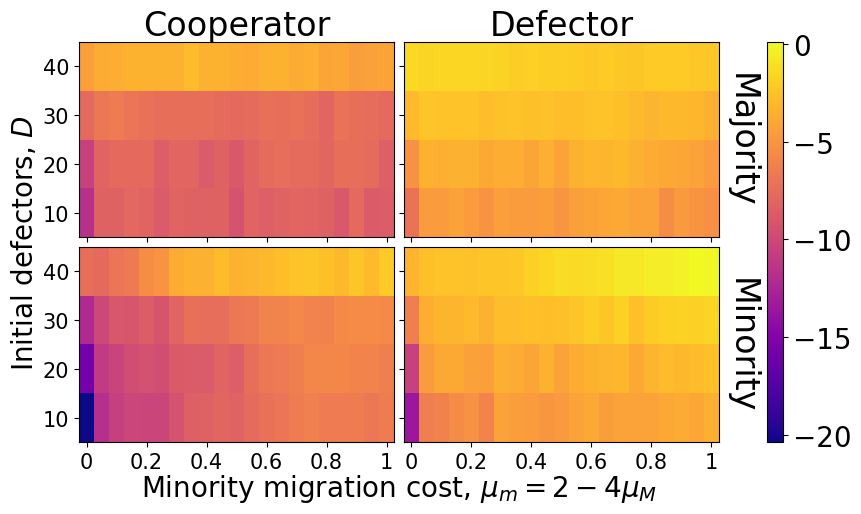

In [5]:
fig,axs = plt.subplots(figsize=(8,5),ncols=2,nrows=2,
                       sharex=True,sharey=True)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05*5/8,
                    hspace=0.05)
pcp_type_reduced = pcp_type[:,:,:,1:-1,:]

for i in range(2):
    for j in range(2):
        im=axs[i,j].pcolormesh(mu_mesh, D_mesh,
                         np.nanmean(pcp_type[i,j,:,:,:],axis=-1),
                         cmap='plasma',
                         vmin=np.nanmean(pcp_type,axis=-1).min(),
                         vmax=np.nanmean(pcp_type,axis=-1).max())
        axs[i,j].tick_params(axis='both', which='major', labelsize=15)
        axs[i,j].tick_params(axis='both', which='major', labelsize=15)
    axs[0,i].set_xticks([0,0.2,0.4,0.6,0.8,1])
    axs[0,i].set_xticklabels([0,0.2,0.4,0.6,0.8,1])

fig.text(0.5, 0.04, "Minority migration cost, $\mu_m=2-4\mu_M$", ha='center',va='top')
fig.text(0.05, 0.5, "Initial defectors, $D$", va='center', rotation='vertical',ha='right')

pad = 5
axs[0,0].annotate("Cooperator",xy=(0.5, 1), xytext=(0, pad),
                  xycoords='axes fraction', 
                  textcoords='offset points',size='large', 
                  ha='center', va='baseline')
axs[0,1].annotate("Defector",xy=(0.5, 1), xytext=(0, pad),
                  xycoords='axes fraction', 
                  textcoords='offset points',size='large', 
                  ha='center', va='baseline')

axs[0,1].annotate("Majority",xy=(1, 0.5), 
                  xytext=(axs[0,1].yaxis.labelpad,0),
                  xycoords='axes fraction', 
                  textcoords='offset points',
                  size='large', ha='left', va='center',rotation=-90)
axs[1,1].annotate("Minority",xy=(1, 0.5), 
                  xytext=(axs[1,1].yaxis.labelpad,0),
                  xycoords='axes fraction', 
                  textcoords='offset points',
                  size='large', ha='left', va='center',rotation=-90)

cb_ax = fig.add_axes([0.96, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
fig.savefig(folder_fig+"pcp_type.png",bbox_inches='tight')

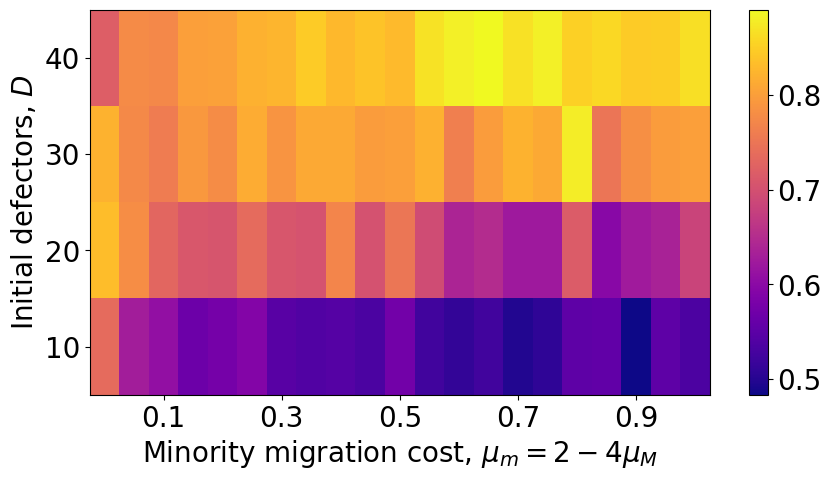

In [6]:
fig,ax = plt.subplots(figsize=(10,5))
# im=ax.imshow(pcp.mean(axis=-1),cmap='plasma',origin='lower')
im=ax.pcolormesh(mu_mesh,D_mesh,cc.mean(axis=-1),cmap='plasma')
fig.colorbar(im)
ax.set_ylabel("Initial defectors, $D$")
ax.set_xlabel("Minority migration cost, $\mu_m = 2 - 4\mu_M$")

ax.set_xticks([0.1,0.3,0.5,0.7,0.9])
ax.set_xticklabels([0.1,0.3,0.5,0.7,0.9])
fig.savefig(folder_fig+"cc.png",bbox_inches='tight')

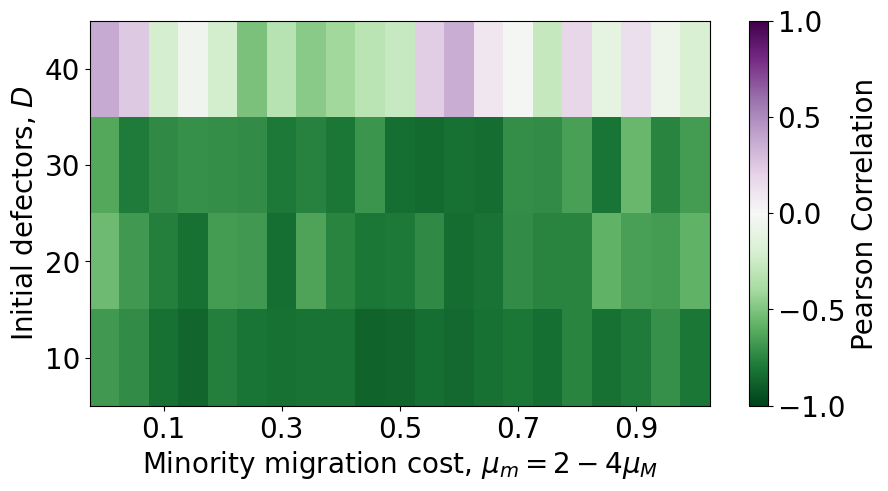

In [9]:
fig,ax = plt.subplots(figsize=(10,5))
R = np.array([[np.corrcoef(cc[i,j,:],pcp[i,j,:])[1,0] for j in range(cc.shape[1])] 
              for i in range(cc.shape[0])])
im=ax.pcolormesh(mu_mesh,D_mesh,R,cmap='PRGn_r',vmin=-1,vmax=1)
fig.colorbar(im,label='Pearson Correlation')
ax.set_ylabel("Initial defectors, $D$")
ax.set_xlabel("Minority migration cost, $\mu_m = 2 - 4\mu_M$")

ax.set_xticks([0.1,0.3,0.5,0.7,0.9])
ax.set_xticklabels([0.1,0.3,0.5,0.7,0.9])
fig.savefig(folder_fig+"corr_coef.png",bbox_inches='tight')

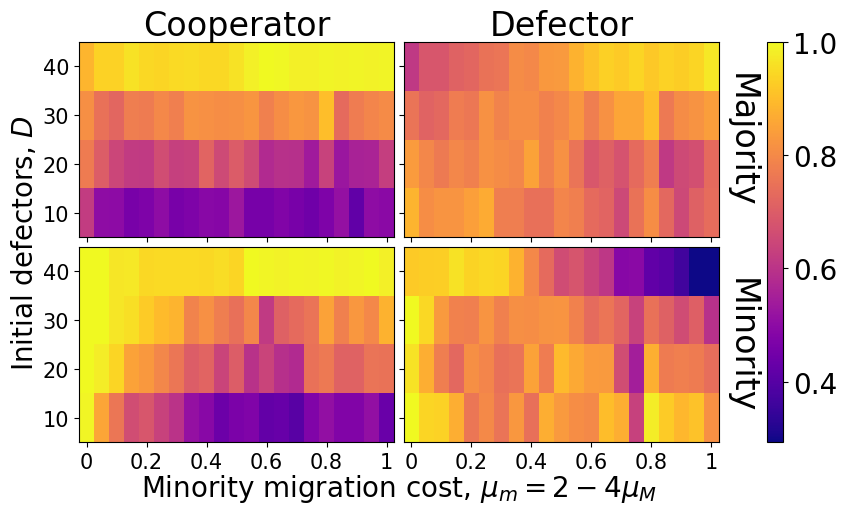

In [7]:
fig,axs = plt.subplots(figsize=(8,5),ncols=2,nrows=2,
                       sharex=True,sharey=True)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05*5/8,
                    hspace=0.05)
cc_type_reduced = cc_type[:,:,:,1:-1,:]

for i in range(2):
    for j in range(2):
        im=axs[i,j].pcolormesh(mu_mesh, D_mesh,
                         np.nanmean(cc_type[i,j,:,:,:],axis=-1),
                         cmap='plasma',
                         vmin=np.nanmean(cc_type_reduced,axis=-1).min(),
                         vmax=np.nanmean(cc_type_reduced,axis=-1).max())
        axs[i,j].tick_params(axis='both', which='major', labelsize=15)
        axs[i,j].tick_params(axis='both', which='major', labelsize=15)
    axs[0,i].set_xticks([0,0.2,0.4,0.6,0.8,1])
    axs[0,i].set_xticklabels([0,0.2,0.4,0.6,0.8,1])

fig.text(0.5, 0.04, "Minority migration cost, $\mu_m=2-4\mu_M$", ha='center',va='top')
fig.text(0.05, 0.5, "Initial defectors, $D$", va='center', rotation='vertical',ha='right')

pad = 5
axs[0,0].annotate("Cooperator",xy=(0.5, 1), xytext=(0, pad),
                  xycoords='axes fraction', 
                  textcoords='offset points',size='large', 
                  ha='center', va='baseline')
axs[0,1].annotate("Defector",xy=(0.5, 1), xytext=(0, pad),
                  xycoords='axes fraction', 
                  textcoords='offset points',size='large', 
                  ha='center', va='baseline')

axs[0,1].annotate("Majority",xy=(1, 0.5), 
                  xytext=(axs[0,1].yaxis.labelpad,0),
                  xycoords='axes fraction', 
                  textcoords='offset points',
                  size='large', ha='left', va='center',rotation=-90)
axs[1,1].annotate("Minority",xy=(1, 0.5), 
                  xytext=(axs[1,1].yaxis.labelpad,0),
                  xycoords='axes fraction', 
                  textcoords='offset points',
                  size='large', ha='left', va='center',rotation=-90)

cb_ax = fig.add_axes([0.96, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
fig.savefig(folder_fig+"cc_type.png",bbox_inches='tight')

# Higher mean cost
mu_mean = 0.8
mu_M = 1-mu_m/4

In [9]:
folder = 'Data/Fixed Strategy/Two cost fixed mean/08_'
T=200
N=50
D=[10,20,30,40]
R=5
phi=5
L = 50
runs=50
mu_min=np.arange(0,1.05,0.05)
mu_maj=1-mu_min/4

pcp = np.zeros((len(D),len(mu_min),runs))
pcp_type = np.zeros((2,2,len(D),len(mu_min),runs))
cc = np.zeros((len(D),len(mu_min),runs))
cc_type = np.zeros((2,2,len(D),len(mu_min),runs))

for i in range(len(D)):
    for k in trange(runs):
        for j in range(len(mu_min)):
            mu = [mu_min[j]]*(N//5) + [mu_maj[j]]*(4*N//5)
            random.shuffle(mu)
            world = pollution.World(L=L,N=N,D=D[i],phi=5,R=5,M_nu=0,mu=mu)
            pcp[i,j,k] -= world.per_capita_pollution()
            for t in range(T):
                world.step()
            pcp[i,j,k] += world.per_capita_pollution()
            pcp_type[0,0,i,j,k] = np.nanmean([world.pollution_grid[a.position] 
                                           for a in world.agents 
                                           if a.type=='c' and a.mu==mu_maj[j]])
            pcp_type[0,1,i,j,k] = np.nanmean([world.pollution_grid[a.position] 
                                           for a in world.agents 
                                           if a.type=='d' and a.mu==mu_maj[j]])
            pcp_type[1,0,i,j,k] = np.nanmean([world.pollution_grid[a.position] 
                                           for a in world.agents 
                                           if a.type=='c' and a.mu==mu_min[j]])
            pcp_type[1,1,i,j,k] = np.nanmean([world.pollution_grid[a.position] 
                                           for a in world.agents 
                                           if a.type=='d' and a.mu==mu_min[j]])
            clusters = world.observe_clusters()
            if len(clusters)>0:
                for c in range(len(clusters)):
                    clusters[0].update(clusters[c])
                cc[i,j,k] = len(clusters[0])/len(world.agents)
                cc_type[:,:,i,j,k] = world.cluster_breakdown(ccs=clusters,mu_vals=[mu_maj[j],mu_min[j]])
np.savetxt(folder+'pcp.csv',pcp.reshape(len(D)*len(mu_min),runs))
np.savetxt(folder+'pcp_type.csv',pcp_type.reshape(2*2*len(D)*len(mu_min),runs))
np.savetxt(folder+'cc.csv',cc.reshape(len(D)*len(mu_min),runs))
np.savetxt(folder+'cc_type.csv',cc_type.reshape(2*2*len(D)*len(mu_min),runs))

100%|███████████████████████████████████████████| 50/50 [29:23<00:00, 35.27s/it]


In [11]:
folder='Data/Fixed Strategy/Two cost fixed mean/08_'
pcp = np.loadtxt(folder+'pcp.csv').reshape(4,len(np.arange(0,1.05,0.05)),50)
pcp_type = np.loadtxt(folder+'pcp_type.csv').reshape(2,2,4,len(np.arange(0,1.05,0.05)),50)
cc = np.loadtxt(folder+'cc.csv').reshape(4,len(np.arange(0,1.05,0.05)),50)
cc_type = np.loadtxt(folder+'cc_type.csv').reshape(2,2,4,len(np.arange(0,1.05,0.05)),50)

D=[10,20,30,40]
R=5
phi=5
L = 50
runs=50
mu_min=np.arange(0,1.05,0.05)
D_corners = [5,15,25,35,45]
mu_rich_corners = np.diff(np.array([-0.05]+list(mu_min)+[1.05]))/2 + np.arange(-0.05,1.05,0.05)

mu_mesh,D_mesh = np.meshgrid(mu_rich_corners,D_corners)
folder_fig = 'Figures/Fixed Strategy/Two cost fixed mean/08_'

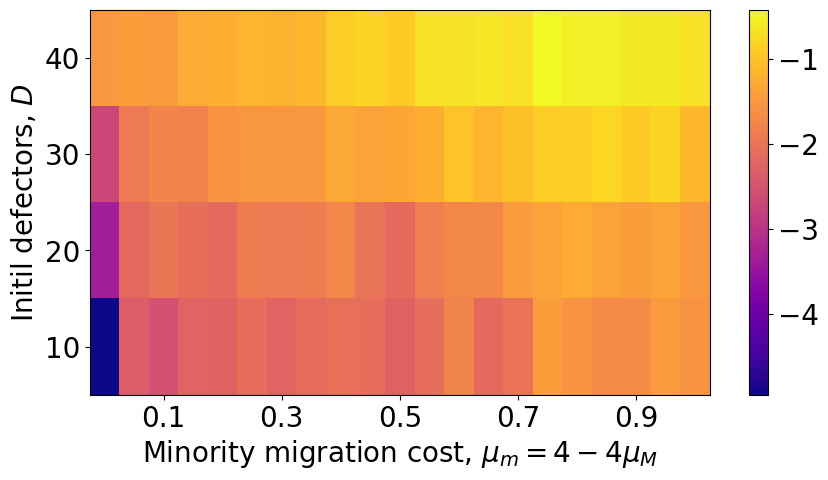

In [12]:
fig,ax = plt.subplots(figsize=(10,5))
# im=ax.imshow(pcp.mean(axis=-1),cmap='plasma',origin='lower')
im=ax.pcolormesh(mu_mesh,D_mesh,pcp.mean(axis=-1),cmap='plasma')
fig.colorbar(im)
ax.set_ylabel("Initil defectors, $D$")
ax.set_xlabel("Minority migration cost, $\mu_m = 4 - 4\mu_M$")

ax.set_xticks([0.1,0.3,0.5,0.7,0.9])
ax.set_xticklabels([0.1,0.3,0.5,0.7,0.9])
fig.savefig(folder_fig+"pcp.png",bbox_inches='tight')

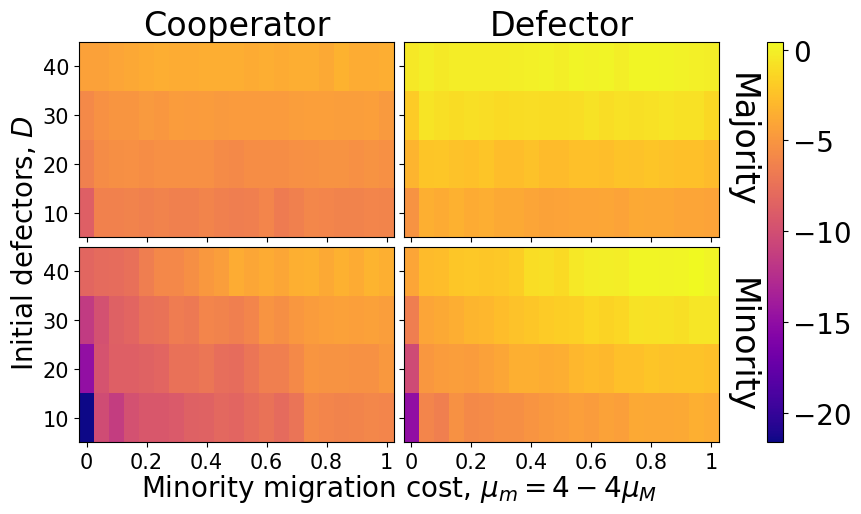

In [13]:
fig,axs = plt.subplots(figsize=(8,5),ncols=2,nrows=2,
                       sharex=True,sharey=True)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05*5/8,
                    hspace=0.05)
pcp_type_reduced = pcp_type[:,:,:,1:-1,:]

for i in range(2):
    for j in range(2):
        im=axs[i,j].pcolormesh(mu_mesh, D_mesh,
                         np.nanmean(pcp_type[i,j,:,:,:],axis=-1),
                         cmap='plasma',
                         vmin=np.nanmean(pcp_type,axis=-1).min(),
                         vmax=np.nanmean(pcp_type,axis=-1).max())
        axs[i,j].tick_params(axis='both', which='major', labelsize=15)
        axs[i,j].tick_params(axis='both', which='major', labelsize=15)
    axs[0,i].set_xticks([0,0.2,0.4,0.6,0.8,1])
    axs[0,i].set_xticklabels([0,0.2,0.4,0.6,0.8,1])

fig.text(0.5, 0.04, "Minority migration cost, $\mu_m=4-4\mu_M$", ha='center',va='top')
fig.text(0.05, 0.5, "Initial defectors, $D$", va='center', rotation='vertical',ha='right')

pad = 5
axs[0,0].annotate("Cooperator",xy=(0.5, 1), xytext=(0, pad),
                  xycoords='axes fraction', 
                  textcoords='offset points',size='large', 
                  ha='center', va='baseline')
axs[0,1].annotate("Defector",xy=(0.5, 1), xytext=(0, pad),
                  xycoords='axes fraction', 
                  textcoords='offset points',size='large', 
                  ha='center', va='baseline')

axs[0,1].annotate("Majority",xy=(1, 0.5), 
                  xytext=(axs[0,1].yaxis.labelpad,0),
                  xycoords='axes fraction', 
                  textcoords='offset points',
                  size='large', ha='left', va='center',rotation=-90)
axs[1,1].annotate("Minority",xy=(1, 0.5), 
                  xytext=(axs[1,1].yaxis.labelpad,0),
                  xycoords='axes fraction', 
                  textcoords='offset points',
                  size='large', ha='left', va='center',rotation=-90)

cb_ax = fig.add_axes([0.96, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
fig.savefig(folder_fig+"pcp_type.png",bbox_inches='tight')

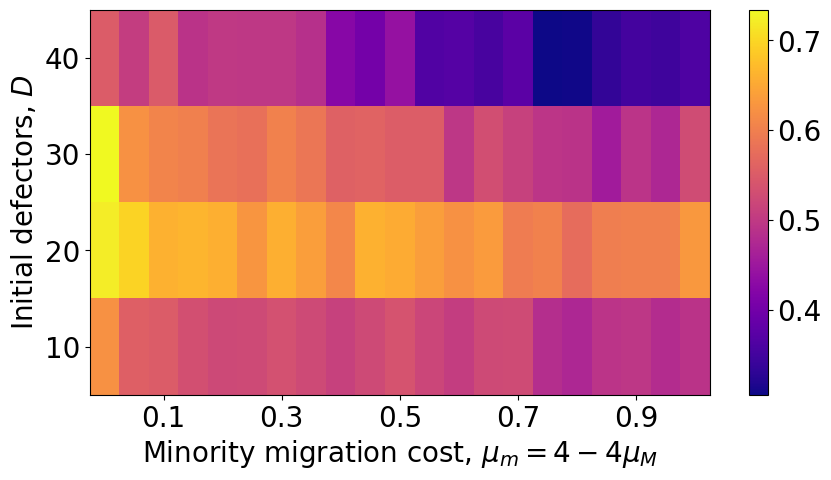

In [17]:
fig,ax = plt.subplots(figsize=(10,5))
# im=ax.imshow(pcp.mean(axis=-1),cmap='plasma',origin='lower')
im=ax.pcolormesh(mu_mesh,D_mesh,cc.mean(axis=-1),cmap='plasma')
fig.colorbar(im)
ax.set_ylabel("Initial defectors, $D$")
ax.set_xlabel("Minority migration cost, $\mu_m = 4 - 4\mu_M$")

ax.set_xticks([0.1,0.3,0.5,0.7,0.9])
ax.set_xticklabels([0.1,0.3,0.5,0.7,0.9])
fig.savefig(folder_fig+"cc.png",bbox_inches='tight')

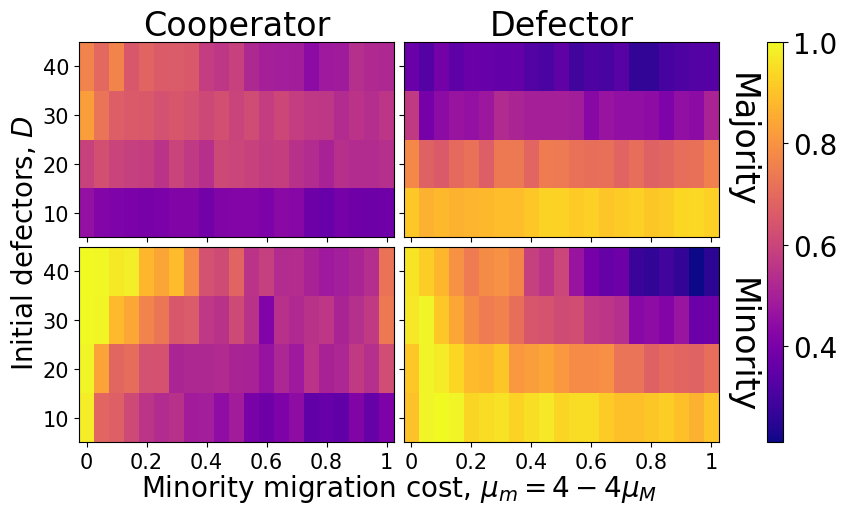

In [15]:
fig,axs = plt.subplots(figsize=(8,5),ncols=2,nrows=2,
                       sharex=True,sharey=True)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05*5/8,
                    hspace=0.05)
cc_type_reduced = cc_type[:,:,:,1:-1,:]

for i in range(2):
    for j in range(2):
        im=axs[i,j].pcolormesh(mu_mesh, D_mesh,
                         np.nanmean(cc_type[i,j,:,:,:],axis=-1),
                         cmap='plasma',
                         vmin=np.nanmean(cc_type_reduced,axis=-1).min(),
                         vmax=np.nanmean(cc_type_reduced,axis=-1).max())
        axs[i,j].tick_params(axis='both', which='major', labelsize=15)
        axs[i,j].tick_params(axis='both', which='major', labelsize=15)
    axs[0,i].set_xticks([0,0.2,0.4,0.6,0.8,1])
    axs[0,i].set_xticklabels([0,0.2,0.4,0.6,0.8,1])

fig.text(0.5, 0.04, "Minority migration cost, $\mu_m=4-4\mu_M$", ha='center',va='top')
fig.text(0.05, 0.5, "Initial defectors, $D$", va='center', rotation='vertical',ha='right')

pad = 5
axs[0,0].annotate("Cooperator",xy=(0.5, 1), xytext=(0, pad),
                  xycoords='axes fraction', 
                  textcoords='offset points',size='large', 
                  ha='center', va='baseline')
axs[0,1].annotate("Defector",xy=(0.5, 1), xytext=(0, pad),
                  xycoords='axes fraction', 
                  textcoords='offset points',size='large', 
                  ha='center', va='baseline')

axs[0,1].annotate("Majority",xy=(1, 0.5), 
                  xytext=(axs[0,1].yaxis.labelpad,0),
                  xycoords='axes fraction', 
                  textcoords='offset points',
                  size='large', ha='left', va='center',rotation=-90)
axs[1,1].annotate("Minority",xy=(1, 0.5), 
                  xytext=(axs[1,1].yaxis.labelpad,0),
                  xycoords='axes fraction', 
                  textcoords='offset points',
                  size='large', ha='left', va='center',rotation=-90)

cb_ax = fig.add_axes([0.96, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
fig.savefig(folder_fig+"cc_type.png",bbox_inches='tight')

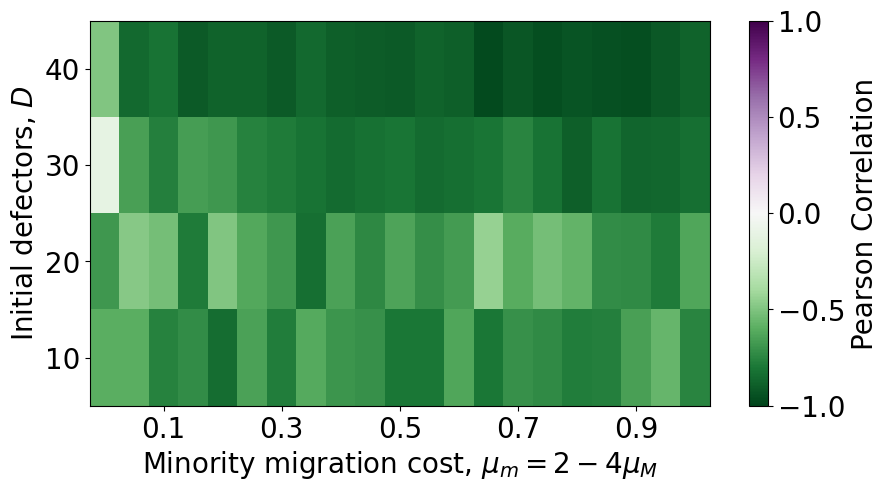

In [16]:
fig,ax = plt.subplots(figsize=(10,5))
R = np.array([[np.corrcoef(cc[i,j,:],pcp[i,j,:])[1,0] for j in range(cc.shape[1])] 
              for i in range(cc.shape[0])])
im=ax.pcolormesh(mu_mesh,D_mesh,R,cmap='PRGn_r',vmin=-1,vmax=1)
fig.colorbar(im,label='Pearson Correlation')
ax.set_ylabel("Initial defectors, $D$")
ax.set_xlabel("Minority migration cost, $\mu_m = 2 - 4\mu_M$")

ax.set_xticks([0.1,0.3,0.5,0.7,0.9])
ax.set_xticklabels([0.1,0.3,0.5,0.7,0.9])
fig.savefig(folder_fig+"corr_coef.png",bbox_inches='tight')

# Dist moved

In [24]:
T = 200
N = 100
D = 3*N//5
L = 20
mu_poor = 0.8
mu_rich = 1-mu_poor
mu=[mu_poor]*(4*N//5) + [mu_rich]*(N//5)
random.shuffle(mu)
runs = 50
# dist_moved = np.zeros(T+1)
dist_moved_d = np.zeros([runs,D,T+1])
dist_moved_c = np.zeros([runs,N-D,T+1])
# for i in trange(T+1):
#     pcp[i]=world.per_capita_pollution()
#     pce[i]=world.per_capita_expense()
#     world.step()
for r in trange(runs):
    world = pollution.World(L=L,N=N,D=D,phi=5,R=5,M_nu=0,epsilon=0,mu=mu)
    for t in range(T+1):
        world.step()
        dist_moved_d[r,:,t] = [a.dist_moved for a in world.agents if a.type=='d']
        dist_moved_c[r,:,t] = [a.dist_moved for a in world.agents if a.type=='c']

100%|███████████████████████████████████████████| 50/50 [01:26<00:00,  1.73s/it]


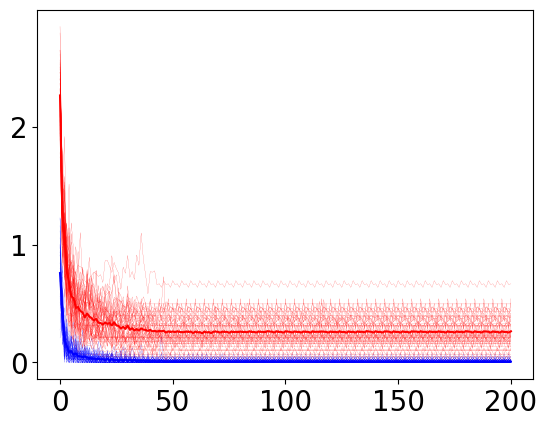

In [25]:
# for i in range(D):
#     plt.plot(range(T+1),dist_moved_d[i,:],c='r',lw=0.1)
    
# for i in range(N-D):
#     plt.plot(range(T+1),dist_moved_c[i,:],c='b',lw=0.1)
for i in range(runs):
    plt.plot(range(T+1),dist_moved_d[i,:,:].mean(axis=0),c='r',lw=0.1)
    plt.plot(range(T+1),dist_moved_c[i,:,:].mean(axis=0),c='b',lw=0.1)
    
plt.plot(range(T+1),np.mean(dist_moved_d,axis=(0,1)),c='r')
plt.plot(range(T+1),np.mean(dist_moved_c,axis=(0,1)),c='b')
# plt.yscale('log')

In [42]:
# folder = 'Data/Fixed Strategy/Two cost fixed mean/04_'
T=100
N=50
D=[40]
R=5
phi=5
L = 50
runs=50
mu_mean = 0.8
mu_min= np.arange(0,1.05,0.05)
mu_maj= N*mu_mean/D[0]-mu_min/4

# pcp = np.zeros((len(D),len(mu_min),runs))
# pcp_type = np.zeros((2,2,len(D),len(mu_min),runs))
# cc = np.zeros((len(D),len(mu_min),runs))
# cc_type = np.zeros((2,2,len(D),len(mu_min),runs))
dist_moved_d = np.zeros((T,len(D),len(mu_min),runs))
dist_moved_c = np.zeros((T,len(D),len(mu_min),runs))
dist_moved = np.zeros((T,len(D),len(mu_min),runs))

for i in range(len(D)):
    for k in trange(runs):
        for j in range(len(mu_min)):
            mu_M = 0.5-mu_min[j]/4
            mu = [mu_min[j]]*(N//5) + [mu_maj[j]]*(4*N//5)
            random.shuffle(mu)
            world = pollution.World(L=L,N=N,D=D[i],phi=5,R=5,M_nu=0,mu=mu)
#             pcp[i,j,k] -= world.per_capita_pollution()
            for t in range(T):
                world.step()
                dist_moved[t,i,j,k] = np.mean([a.dist_moved for a in world.agents])
                dist_moved_d[t,i,j,k] = np.mean([a.dist_moved for a in world.agents if a.type=='d'])
                dist_moved_c[t,i,j,k] = np.mean([a.dist_moved for a in world.agents if a.type=='c'])
#             pcp[i,j,k] += world.per_capita_pollution()
#             pcp_type[0,0,i,j,k] = np.nanmean([world.pollution_grid[a.position] 
#                                            for a in world.agents 
#                                            if a.type=='c' and a.mu==mu_maj[j]])
#             pcp_type[0,1,i,j,k] = np.nanmean([world.pollution_grid[a.position] 
#                                            for a in world.agents 
#                                            if a.type=='d' and a.mu==mu_maj[j]])
#             pcp_type[1,0,i,j,k] = np.nanmean([world.pollution_grid[a.position] 
#                                            for a in world.agents 
#                                            if a.type=='c' and a.mu==mu_min[j]])
#             pcp_type[1,1,i,j,k] = np.nanmean([world.pollution_grid[a.position] 
#                                            for a in world.agents 
#                                            if a.type=='d' and a.mu==mu_min[j]])
#             clusters = world.observe_clusters()
#             for c in range(len(clusters)):
#                 clusters[0].update(clusters[c])
#             cc[i,j,k] = len(clusters[0])/len(world.agents)
#             cc_type[:,:,i,j,k] = world.cluster_breakdown(ccs=clusters,mu_vals=[mu_maj[j],mu_min[j]])
# np.savetxt(folder+'pcp.csv',pcp.reshape(len(D)*len(mu_min),runs))
# np.savetxt(folder+'pcp_type.csv',pcp_type.reshape(2*2*len(D)*len(mu_min),runs))
# np.savetxt(folder+'cc.csv',cc.reshape(len(D)*len(mu_min),runs))
# np.savetxt(folder+'cc_type.csv',cc_type.reshape(2*2*len(D)*len(mu_min),runs))

100%|███████████████████████████████████████████| 50/50 [14:33<00:00, 17.47s/it]


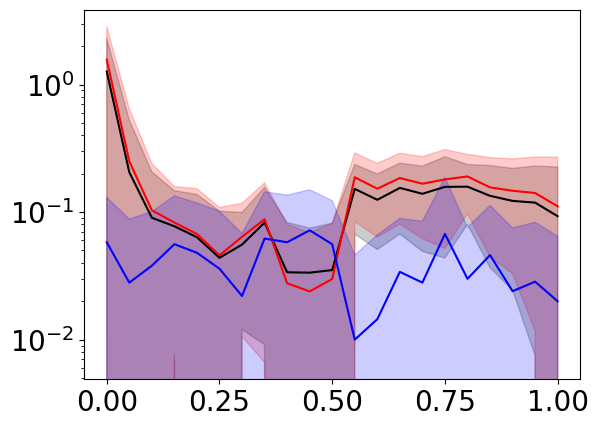

In [41]:
# for r in range(runs):
#     plt.plot(mu_min,dist_moved[-2,0,:,r],c='k',lw=0.05)
#     plt.plot(mu_min,dist_moved_d[-2,0,:,r],c='r',lw=0.05)
#     plt.plot(mu_min,dist_moved_c[-2,0,:,r],c='b',lw=0.05)

plt.plot(mu_min,np.mean(dist_moved[-2,0,:,:],axis=(-1)),c='k')
plt.plot(mu_min,np.mean(dist_moved_d[-2,0,:,:],axis=(-1)),c='r')
plt.plot(mu_min,np.mean(dist_moved_c[-2,0,:,:],axis=(-1)),c='b')

plt.fill_between(mu_min,np.mean(dist_moved[-2,0,:,:],axis=(-1))-
                 np.std(dist_moved[-2,0,:,:],axis=(-1)),
                 np.mean(dist_moved[-2,0,:,:],axis=(-1))+
                 np.std(dist_moved[-2,0,:,:],axis=(-1)),
                 color='k',alpha=0.2)

plt.fill_between(mu_min,np.mean(dist_moved_d[-2,0,:,:],axis=(-1))-
                 np.std(dist_moved_d[-2,0,:,:],axis=(-1)),
                 np.mean(dist_moved_d[-2,0,:,:],axis=(-1))+
                 np.std(dist_moved_d[-2,0,:,:],axis=(-1)),
                 color='r',alpha=0.2)

plt.fill_between(mu_min,np.mean(dist_moved_c[-2,0,:,:],axis=(-1))-
                 np.std(dist_moved_c[-2,0,:,:],axis=(-1)),
                 np.mean(dist_moved_c[-2,0,:,:],axis=(-1))+
                 np.std(dist_moved_c[-2,0,:,:],axis=(-1)),
                 color='b',alpha=0.2)
# plt.xlim([0.05,1])
plt.yscale('log')
# plt.ylim([0,2])

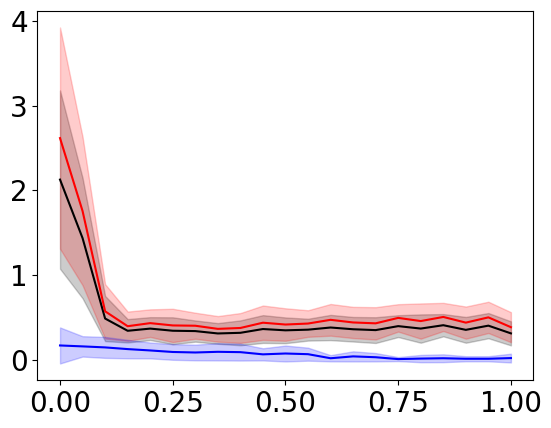

In [46]:
# dist_moved_d[- for r in range(runs):
#     plt.plot(mu_min,dist_moved[-2,0,:,r],c='k',lw=0.05)
#     plt.plot(mu_min,dist_moved_d[-2,0,:,r],c='r',lw=0.05)
#     plt.plot(mu_min,dist_moved_c[-2,0,:,r],c='b',lw=0.05)

plt.plot(mu_min,np.mean(dist_moved[-2,0,:,:],axis=(-1)),c='k')
plt.plot(mu_min,np.mean(dist_moved_d[-2,0,:,:],axis=(-1)),c='r')
plt.plot(mu_min,np.mean(dist_moved_c[-2,0,:,:],axis=(-1)),c='b')

plt.fill_between(mu_min,np.mean(dist_moved[-2,0,:,:],axis=(-1))-
                 np.std(dist_moved[-2,0,:,:],axis=(-1)),
                 np.mean(dist_moved[-2,0,:,:],axis=(-1))+
                 np.std(dist_moved[-2,0,:,:],axis=(-1)),
                 color='k',alpha=0.2)

plt.fill_between(mu_min,np.mean(dist_moved_d[-2,0,:,:],axis=(-1))-
                 np.std(dist_moved_d[-2,0,:,:],axis=(-1)),
                 np.mean(dist_moved_d[-2,0,:,:],axis=(-1))+
                 np.std(dist_moved_d[-2,0,:,:],axis=(-1)),
                 color='r',alpha=0.2)

plt.fill_between(mu_min,np.mean(dist_moved_c[-2,0,:,:],axis=(-1))-
                 np.std(dist_moved_c[-2,0,:,:],axis=(-1)),
                 np.mean(dist_moved_c[-2,0,:,:],axis=(-1))+
                 np.std(dist_moved_c[-2,0,:,:],axis=(-1)),
                 color='b',alpha=0.2)
# plt.xlim([0.05,1])
# plt.yscale('log')
# plt.ylim([0,2])2].max()